In [1]:
import tensorflow as tf
import keras
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPool2D
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
%matplotlib inline

C:\Users\allan\miniconda3\envs\tf2.9\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
mnist_dataset = tf.keras.datasets.mnist

In [3]:
print(mnist_dataset)

<module 'keras.api._v2.keras.datasets.mnist' from 'C:\\Users\\allan\\miniconda3\\envs\\tf2.9\\lib\\site-packages\\keras\\api\\_v2\\keras\\datasets\\mnist\\__init__.py'>


In [4]:
(x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()
x_train = tf.expand_dims(x_train, axis = -1)
x_train = tf.cast(x_train, dtype = 'float32')

x_test = tf.expand_dims(x_test, axis = -1)
x_test = tf.cast(x_test, dtype = 'float32')


In [5]:
def plot_data(image_array):
    plt.imshow(image_array)
    plt.show()

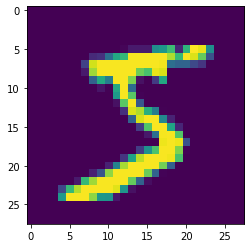

In [6]:
plot_data(x_train[0])

In [7]:
print(len(y_train))

60000


In [8]:
class my_classifier(tf.keras.Model):
    def __init__(self):
        super(my_classifier, self).__init__()
        self.conv2d1 = Conv2D(filters = 8, kernel_size = (3,3), strides = (1,1), activation = 'relu', padding = 'valid')
        self.maxpool1 = MaxPool2D(pool_size = (2,2), strides = (2,2))
        self.dense1 = Dense(units = 100, activation = 'relu')
        self.dense2 = Dense(units = 100, activation = 'relu')
        self.classification_layer = Dense(units = 10, activation = 'softmax')
        pass
    
    def call(self, inputs):
        x = self.conv2d1(inputs)
        x = self.maxpool1(x)
        x = Flatten()(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.classification_layer(x)
        return x
    pass

class standard_model:
    def __init__(self):
        inputs = Input(shape = (28, 28))
        x = Flatten()(inputs)
        x = Dense(units = 128, activation = 'relu')(x)
        #x = Dense(units = 100, activation = 'relu')(x)
        x = Dense(units = 10, activation = 'softmax')(x)
        self.model = tf.keras.Model(inputs = inputs, outputs = x)
        pass
    
    def get_model(self):
        return self.model
    pass


In [9]:
model = my_classifier()
#model = model_builder(Input(shape = (28, 28)))
#model = model_builder.get_model()


In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [11]:
train_dataset = train_dataset.shuffle(buffer_size = 1024)
train_dataset = train_dataset.batch(batch_size = 32)


In [12]:
loss_calculator = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
train_metric = tf.keras.metrics.SparseCategoricalAccuracy()
validation_metric = tf.keras.metrics.SparseCategoricalAccuracy()
model.compile(optimizer=optimizer, loss=loss_calculator)

In [13]:
def train_batches_for_single_epoch(model, dataset):
    losses = []
    for step, (x_batch_train, y_batch_train) in enumerate(dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train)
            loss_value = loss_calculator(y_true = y_batch_train, y_pred = logits)
            losses.append(loss_value)
            gradients = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))
            train_metric.update_state(y_batch_train, logits)
        pass
    return losses

In [14]:
def validate_the_model(model, x_val, y_val):
    logits = model(x_val)
    validation_metric.update_state(y_val, logits)
    validation_loss = loss_calculator(y_true = y_val, y_pred = logits)
    validation_acc = validation_metric.result()
    #print("Validation loss is {0} and validation accuracy is {1}".format(str(np.mean(validation_loss)), validation_acc))
    validation_metric.reset_states()    
    return np.mean(validation_loss), validation_acc



In [19]:
def train_all_epochs(model, num_of_epochs, dataset):
    for epoch in range(num_of_epochs):
        current_loss = train_batches_for_single_epoch(model, dataset)
        train_acc = train_metric.result()
        
        train_metric.reset_states()
        val_loss, val_acc = validate_the_model(model, x_test, y_test)
        train_loss = np.mean(current_loss)
        
        print("Training loss = {0:.4f} ||Training accuracy = {1:.4f} || Validation loss = {2:.4f} || Validation accuracy = {3:.4f}".format(train_loss, train_acc, val_loss, val_acc))
        pass
    pass

In [20]:
train_all_epochs(model, 5, train_dataset)
model.summary()

Training loss = 0.0736 ||Training accuracy = 0.9773 || Validation loss = 0.1025 || Validation accuracy = 0.9739
Training loss = 0.0568 ||Training accuracy = 0.9825 || Validation loss = 0.1108 || Validation accuracy = 0.9693
Training loss = 0.0444 ||Training accuracy = 0.9856 || Validation loss = 0.0853 || Validation accuracy = 0.9780
Training loss = 0.0386 ||Training accuracy = 0.9879 || Validation loss = 0.0940 || Validation accuracy = 0.9772
Training loss = 0.0324 ||Training accuracy = 0.9904 || Validation loss = 0.0969 || Validation accuracy = 0.9789
Model: "my_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  80        
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                     